In [5]:
!pip install nltk tensorflow scikit-learn



In [6]:
import pandas as pd
import numpy as np
import nltk
import string
import re
import matplotlib.pyplot as plt

In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from google.colab import files
uploaded = files.upload()

Saving Fake.csv to Fake (2).csv
Saving True.csv to True (2).csv


In [9]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
df_fake.head()
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
# Add labels (1 = True, 0 = Fake)
df_true['label'] = 1
df_fake['label'] = 0

In [13]:
# Merge datasets
df = pd.concat([df_true, df_fake], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

print("Dataset Shape:", df.shape)
print(df['label'].value_counts())
df.head()

Dataset Shape: (44898, 5)
label
0    23481
1    21417
Name: count, dtype: int64


,title,text,subject,date,label
0,Trump’s ‘Spiritual Advisor’ Is Just Another C...,"It seems that every time we turn around, there...",News,"July 11, 2016",0
1,OBAMA’S GAL PAL Loretta Lynch WON’T RECUSE HER...,Reasonable Americans expected never expected u...,Government News,"Jul 1, 2016",0
2,Irish PM cautious over two-year Brexit transit...,DUBLIN (Reuters) - The Brexit transition perio...,worldnews,"December 8, 2017",1
3,STAR WARS 2.0: Washington’s Battle to Fund Spa...,"21st Century Wire says In 1983, US President R...",US_News,"July 14, 2017",0
4,"Despicable Trump Announces An End To DACA, Wi...",We always knew that Donald Trump was a heartle...,News,"September 3, 2017",0


In [14]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import re
import nltk


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

nltk.download('punkt')
df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42
)


In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [17]:
# Naïve Bayes ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("\nNaïve Bayes Results:")
print(classification_report(y_test, y_pred_nb))


Naïve Bayes Results:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4617
           1       0.93      0.91      0.92      4363

    accuracy                           0.93      8980
   macro avg       0.93      0.92      0.92      8980
weighted avg       0.93      0.93      0.93      8980



In [18]:
# --- Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4617
           1       1.00      1.00      1.00      4363

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [19]:
#  LSTM Model
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 300
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

In [20]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = lstm_model.fit(X_train_pad, y_train, epochs=2, batch_size=64, validation_data=(X_test_pad, y_test))
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
print("\nLSTM Results:")
print(classification_report(y_test, y_pred_lstm))


Epoch 1/2
562/562 [==============================] - 775s 1s/step - loss: 0.0996 - accuracy: 0.9693 - val_loss: 0.0406 - val_accuracy: 0.9893
Epoch 2/2
281/281 [==============================] - 35s 123ms/step

LSTM Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4617
           1       0.99      1.00      0.99      4363

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



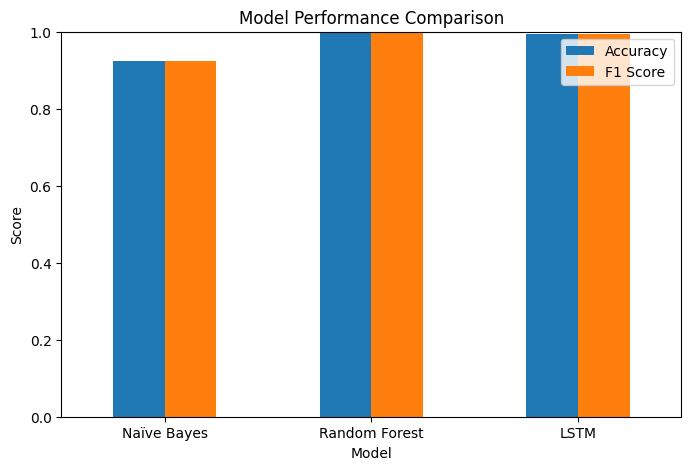

In [22]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Extract metrics from classification reports
nb_report = classification_report(y_test, y_pred_nb, output_dict=True)
rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
lstm_report = classification_report(y_test, y_pred_lstm, output_dict=True)

nb_acc = nb_report['accuracy']
rf_acc = rf_report['accuracy']
lstm_acc = lstm_report['accuracy']

nb_f1 = nb_report['weighted avg']['f1-score']
rf_f1 = rf_report['weighted avg']['f1-score']
lstm_f1 = lstm_report['weighted avg']['f1-score']

metrics_df = pd.DataFrame({
    "Model": ["Naïve Bayes", "Random Forest", "LSTM"],
    "Accuracy": [nb_acc, rf_acc, lstm_acc],
    "F1 Score": [nb_f1, rf_f1, lstm_f1]
})
metrics_df.plot(x="Model", y=["Accuracy", "F1 Score"], kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()

281/281 [==============================] - 35s 125ms/step


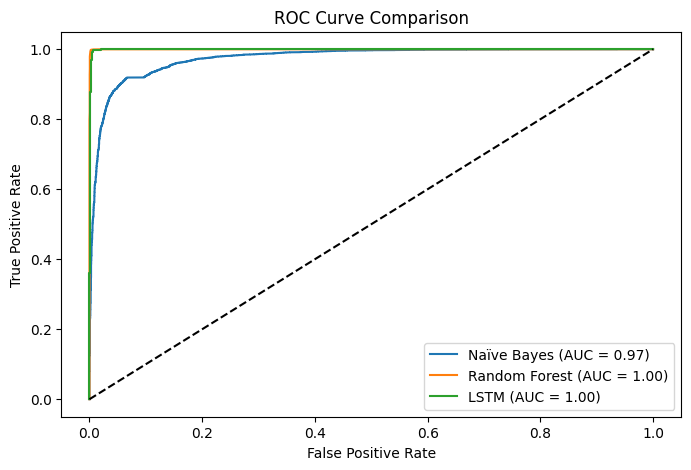

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8,5))
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_model.predict_proba(X_test_tfidf)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test_tfidf)[:, 1])
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_model.predict(X_test_pad))

nb_roc = roc_auc_score(y_test, nb_model.predict_proba(X_test_tfidf)[:, 1])
rf_roc = roc_auc_score(y_test, rf_model.predict_proba(X_test_tfidf)[:, 1])
lstm_roc = roc_auc_score(y_test, lstm_model.predict(X_test_pad))


plt.plot(fpr_nb, tpr_nb, label=f"Naïve Bayes (AUC = {nb_roc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_roc:.2f})")
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {lstm_roc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()